# 네이버 증권 크롤링
- 현재는 기업현황 페이지에서 자료 긁어오는 것만 실시
- 향후 재무분석도 실시 가능
- Selenium을 통해 xpath를 click할 수 있어 숨겨진 자료도 확인 가능
# Step
- 자료 수집하기
- 자료 저장하기
- 자료 불러오기
- 자료 처리하기

In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
from urllib.request import HTTPError
import pandas as pd
import re
from selenium import webdriver
import FinanceDataReader as fdr
import datetime
import numpy as np
import time
from dateutil.relativedelta import relativedelta
import math

In [2]:
# 종목 불러오기
def stock_code_reset(stock_code):
    corp_code = corp_df[corp_df['stock_code'] == stock_code].iloc[0, 0]
    return corp_code

import pandas as pd
import xml.etree.ElementTree as ET

tree = ET.parse('../Raw/Corpcode/corp_num/CORPCODE.xml')
root = tree.getroot()

corp_df = pd.DataFrame(columns=['corp_code','corp_name','stock_code','modify_date'])
for company in root.iter('list'):
    stock_code = company.findtext('stock_code')
    stock_code = stock_code.strip()
    if stock_code:
        company_dict = {
            'corp_code':company.findtext('corp_code'),
            'corp_name':company.findtext('corp_name'),
            'stock_code':company.findtext('stock_code'),
            'modify_date':company.findtext('modify_date')
        }
        corp_df = corp_df.append(company_dict, ignore_index=True)
        
import warnings
warnings.filterwarnings('ignore') # 경고메시지 무시하기

import FinanceDataReader as fdr
stock_list_kospi = fdr.StockListing('KOSPI')['Symbol'].to_list()
stock_list_kosdaq = fdr.StockListing('KOSDAQ')['Symbol'].to_list()
# stock_df_del = fdr.StockListing('KRX-DELISTING')
# stock_list_del = stock_df_del[(stock_df_del['Market'] == "KOSPI") | (stock_df_del['Market'] == "KOSDAQ")]['Symbol'].to_list()

stock_list = stock_list_kospi+stock_list_kosdaq

import re
# stock_code_list 정제하기 (우선주, 리츠, 옵션) -> 6자리 숫자만, 맨 앞자리에 0 들어가는 것만
stock_code_list = []
for stock_code in stock_list:
    stock_code = re.findall("\d+", stock_code)[0] # 숫자만 추출한 뒤 첫번째 것만 사용
    if (stock_code[-1] == '0') and (len(stock_code) == 6):
        stock_code_list.append(stock_code)
len(stock_code_list)

2834

In [3]:
# api set
import sys
sys.path.append('C://Users//malko/anaconda3/envs/py38_64/lib/site-packages/dart-fss/')
from dart_fss.auth import set_api_key, get_api_key
from dart_fss.corp import get_corp_list
api_key = open('../crtfc_key.txt',mode='r').readline()
set_api_key(api_key=api_key)
print("api set 완료")

api set 완료


In [4]:
# 거래소에 없는 종목 제외
corp_list = get_corp_list()
none_list=[]
for stock_code in stock_code_list:
    data = corp_list.find_by_stock_code(stock_code)
    if data == None:
        none_list.append(stock_code)
        
import numpy as np
stock_code_list_reset = []
for stock_code in stock_code_list:
    if not np.all(corp_df[corp_df['stock_code'] == stock_code] == None):
        stock_code_list_reset.append(stock_code)
len(stock_code_list_reset)

Output()

Output()

Output()

2310

# 자료 수집하기

In [11]:
def naver_finance_analysis(stock_code : str):
    sleep = 0.1
    url = 'https://navercomp.wisereport.co.kr/v2/company/c1030001.aspx?cmp_cd={}&cn='.format(stock_code)
    chrome_driver_path = "chromedriver.exe"
    driver=webdriver.Chrome(chrome_driver_path)
    driver.get(url)
    # 포괄손익계산서
    driver.find_element_by_xpath('//*[@id="frqTyp1"]').click()
    driver.find_element_by_xpath('//*[@id="hfinGubun"]').click()
    driver.find_element_by_xpath('//*[@id="rpt_tab1"]').click()
    time.sleep(sleep)
#     print('cis')
    html = driver.page_source
    soup = BeautifulSoup(html,'html.parser')
    table = soup.select('table')
    table_html = str(table)
    table_df_list = pd.read_html(table_html)
    table_cis = table_df_list[5]
    df_cis = table_reset(table_cis,stock_code)
    # df_cis가 df_bs와 동일하게 나오는 것을 방지하기 위해 반복.
    # 재무상태표
    df_bs = df_cis
    driver.find_element_by_xpath('//*[@id="rpt_tab2"]').click()
    # 다르다x
    while len(df_bs.columns) == len(df_cis.columns):
#         print('bs')
        time.sleep(sleep)
        html = driver.page_source
        soup = BeautifulSoup(html,'html.parser')
        table = soup.select('table')
        table_html = str(table)
        table_df_list = pd.read_html(table_html)
        table_bs = table_df_list[5]
        df_bs = table_reset(table_bs,stock_code)
        if len(df_cis.columns) == 2:
            break
    # df_cf가 df_bs와 동일하게 나오는 것을 방지하기 위해 반복.
    # 현금흐름표
    df_cf = df_bs
    driver.find_element_by_xpath('//*[@id="rpt_tab3"]').click()
    while len(df_cf.columns) == len(df_bs.columns):        
#         print('cf')
        time.sleep(sleep)
        html = driver.page_source
        soup = BeautifulSoup(html,'html.parser')
        table = soup.select('table')
        table_html = str(table)
        table_df_list = pd.read_html(table_html)
        table_cf = table_df_list[5]
        df_cf = table_reset(table_cf,stock_code)
        if len(df_cis.columns) == 2:
            break
    # 병합
    df = pd.merge(df_cis,df_bs,on=list(set(df_cis.columns) & set(df_bs.columns)))
    df = pd.merge(df, df_cf,on=list(set(df.columns) & set(df_cf.columns)))
    # 전체 결측이면 제거
    df = df[~(df.isnull().sum(axis=1) == len(df.columns)-2)]
    # 창닫기
    driver.close()
    return df

In [6]:
def table_reset(table,stock_code):
    value_list = table['항목']
    value_list = [clearingValueList(item) for item in value_list]
    column_list = ['stock_code','period']+value_list
    
    df = pd.DataFrame(index=range(5),columns = column_list)
    
    df.stock_code = stock_code
    date_list = [date[0:4]+date[5:7] for date in table.columns[1:6]]
    df.period = date_list
    for i in range(len(table.index)):
        df[df.columns[i+2]] = table.iloc[i,:][1:6].to_list()
    
    df.dropna(axis=1,how='all',inplace=True)
    return df

In [7]:
def clearingValueList (value_item):
    value_item = value_item.replace('*','')
    value_item = value_item.replace('펼치기','')
    value_item = value_item.replace(' ','')
    return value_item

In [72]:
t1=time.time()
# stock_list = stock_code_list_reset
# stock_list_error=[]

# data_all = pd.DataFrame()
for stock_code in stock_list_error[19:20]:
    try:
        data_temp = naver_finance_analysis(stock_code)
        data_all = pd.merge(data_all.T, data_temp.T, right_index=True, left_index=True, how='outer').drop_duplicates().T.reset_index(drop=True)
#         if stock_code_list_reset.index(stock_code)%10 == 0:
#             print(stock_code_list_reset.index(stock_code))
#         else:
#             continue
    except:
        print(stock_code)
#         stock_list_error.append(stock_code)
        
t2=time.time()
print((t2-t1)/60)
# data_all.to_csv('../Raw_Finance/finance_naver.csv', encoding='utf-8-sig')

0.18158721129099528


# 자료 저장하기 / 처리하기

# 자료 불러오기

In [ ]:
# csv 읽어서 dataframe 다시 만들기
data_all = pd.read_csv('../Raw_Finance/finance_naver.csv',index_col=0)
data_all['stock_code'] = data_all['stock_code'].apply(lambda x : '%06d'%x)
data_all

In [221]:
columns = ['stock_code','period','총자산','현금','부채','지배자산','매출액','매출원가','매출총이익',
           '판관비','영업이익', '당기순이익','지배순이익','영업활동현금흐름']

# ['매출액','매출원가','매출총이익','판관비','영업이익','당기순이익','지배순이익','영업활동현금흐름']

In [82]:
data_all_converted = {}
for i in range(len(data_all.index)):
    if math.isnan(data_all['자산총계'][i]):
        data_all['자산총계'][i] = data_all['자산'][i]
    if math.isnan(data_all['현금및현금성자산'][i]):
        data_all['현금및현금성자산'][i] = data_all['현금및예치금'][i]
    if math.isnan(data_all['부채총계'][i]):
        data_all['부채총계'][i] = data_all['부채'][i]
data_all_converted['stock_code'] = data_all['stock_code'].to_list()
data_all_converted['period'] = data_all['period'].to_list()
data_all_converted['총자산'] = data_all['자산총계'].to_list()
data_all_converted['현금'] = data_all['현금및현금성자산'].to_list()
data_all_converted['부채'] = data_all['부채총계'].to_list()
data_all_converted['지배자산'] = data_all['지배주주지분'].to_list()
data_all_converted['매출액'] = data_all['매출액(수익)'].to_list()
data_all_converted['매출원가'] = data_all['매출원가'].to_list()
data_all_converted['매출총이익'] = data_all['매출총이익'].to_list()
data_all_converted['판관비'] = data_all['판매비와관리비'].to_list()
data_all_converted['영업이익'] = data_all['영업이익'].to_list()
data_all_converted['당기순이익'] = data_all['당기순이익'].to_list()
data_all_converted['지배순이익'] = data_all['(지배)당기순이익'].to_list()
data_all_converted['영업활동현금흐름'] = data_all['영업활동으로인한현금흐름'].to_list()
data_all_converted = pd.DataFrame(data_all_converted)

<ipython-input-82-cf8443c0e21c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_all['부채총계'][i] = data_all['부채'][i]
<ipython-input-82-cf8443c0e21c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_all['현금및현금성자산'][i] = data_all['현금및예치금'][i]
<ipython-input-82-cf8443c0e21c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_all['자산총계'][i] = data_all['자산'][i]


In [84]:
data_all_converted.to_csv("../Raw_Finance/finance_naver_converted.csv",encoding='utf-8-sig')

In [115]:
stock_code_list = list(set(data_all_converted.stock_code))

In [215]:
data_all_converted_pivot= data_all_converted.pivot_table(index=['stock_code','period'])

In [224]:
# stock_code = stock_code_list[0]
list_all = []
for stock_code in stock_code_list:

    if 202103 in data_all_converted_pivot.loc[stock_code].index:
        data_all_converted_pivot_bs = data_all_converted_pivot.loc[(stock_code,202103),['총자산','현금','부채','지배자산']]
    else:
    #     data_all_converted_pivot_bs = [float('nan'),float('nan'),float('nan'),float('nan')]
        continue
    data_all_converted_pivot_cis_base = data_all_converted_pivot.loc[(stock_code,202006):(stock_code,202103),['매출액','매출원가','매출총이익','판관비','영업이익','당기순이익','지배순이익','영업활동현금흐름']]
    data_all_converted_pivot_cis_base = data_all_converted_pivot_cis_base.dropna()
    if len(data_all_converted_pivot_cis_base) == 4:
        data_all_converted_pivot_cis = data_all_converted_pivot_cis_base.sum()
    else:
        continue
    list_temp = [stock_code,202103]+list(data_all_converted_pivot_bs)+list(data_all_converted_pivot_cis)
    list_all.append(list_temp)

In [226]:
data_all_converted = pd.DataFrame(list_all, columns=columns)

In [228]:
data_all_converted.to_csv("../Raw_Finance/finance_naver_converted.csv",encoding='utf-8-sig')

# 종목명, 주가 다루기

In [5]:
df_krx = fdr.StockListing('KRX') # KRX, KOSPI, KOSDAQ, KONEX, NASDAQ, NYSE, AMEX, SP500
df_krx_wo_nan = df_krx.dropna(subset=['Sector'])
stock_list_all = df_krx_wo_nan['Symbol'].to_list()
print(len(stock_list_all))
# df_etf = fdr.EtfListing('KR')
# df_etf.head()
# df_krx.to_csv('krxlist.csv', index=True, encoding='utf-8-sig')

2379


,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,특수 목적용 기계 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,"박종익, 김세완 (각자 대표이사)",http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,이현우,http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도
...,...,...,...,...,...,...,...,...,...,...
2573,189980,KOSDAQ,흥국에프엔비,비알코올음료 및 얼음 제조업,"과일음료(에이드베이스, 스무디, 착즙쥬스 등)",2015-08-07,12월,"박철범, 오길영",http://www.hyungkuk.com,서울특별시
2574,000540,KOSPI,흥국화재,보험업,손해보험,1974-12-05,12월,권중원,http://www.insurance.co.kr,서울특별시
2577,003280,KOSPI,흥아해운,해상 운송업,외항화물운송업(케미컬탱커),1976-06-29,12월,이환구,http://www.heung-a.com,서울특별시
2578,037440,KOSDAQ,희림,"건축기술, 엔지니어링 및 관련 기술 서비스업",설계 및 감리용역,2000-02-03,12월,"정영균, 이목운, 허철호, 염두성 (각자대표)",http://www.heerim.com,서울특별시


In [102]:
# 거래대금 1억 이상 ETF 분류
etf_list = df_etf['Symbol'].to_list()
etf_trade_list=[]
for i in range(len(etf_list)):
    close = fdr.DataReader(etf_list[i]).loc['2020-09-22',['Close']]
    volume = fdr.DataReader(etf_list[i]).loc['2020-09-22',['Volume']] 
    if int(close) * int(volume) > 1000000000:
        etf_trade_list.append(etf_list[i])
    else:
        continue

# 종목을 정리할 필요가 있음.
# close = fdr.DataReader('069500').loc['2020-09-22',['Close']]
# volume = fdr.DataReader('069500').loc['2020-09-22',['Volume']]
# int(close) * int(volume)

In [2]:
corp_code = '102110'
# date = '2020-1-1'
a=datetime.datetime(2020,1,1)

def date_str (date):
    date_temp=str("%s-%s-%s" %(date.year, date.month, date.day))
    return date_temp

def earning_rate (corp_code, date, duration):
    date1 = date_str(date)
    date2 = date_str(date+relativedelta(months=duration))
    date3 = date_str(date+relativedelta(months=(duration+1)))
    p1 = fdr.DataReader(corp_code,date1,date2).head(1).loc[:,'Close'].values
    p2 = fdr.DataReader(corp_code,date2,date3).head(1).loc[:,'Close'].values
    earning_rate = (p2-p1)/p1
    return earning_rate, date

earning_rate(corp_code,a,1)

(array([-0.01770617]), datetime.datetime(2020, 1, 1, 0, 0))

In [62]:
fdr.DataReader('KR3YT=RR','2020-01-01','2020-02-01').head(1).loc[:,'Close'].values

array([1.355])

In [36]:
a=datetime.datetime(2020,1,1)
c = a + datetime.timedelta(days=2)
b=str("%s-%s-%s" %(a.year, a.month, a.day))
b
c

datetime.datetime(2020, 1, 3, 0, 0)

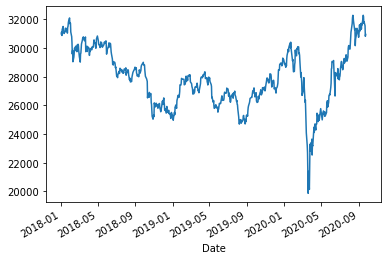

In [85]:
df_cost = fdr.DataReader('069500','2018')
df_cost['Close'].plot()

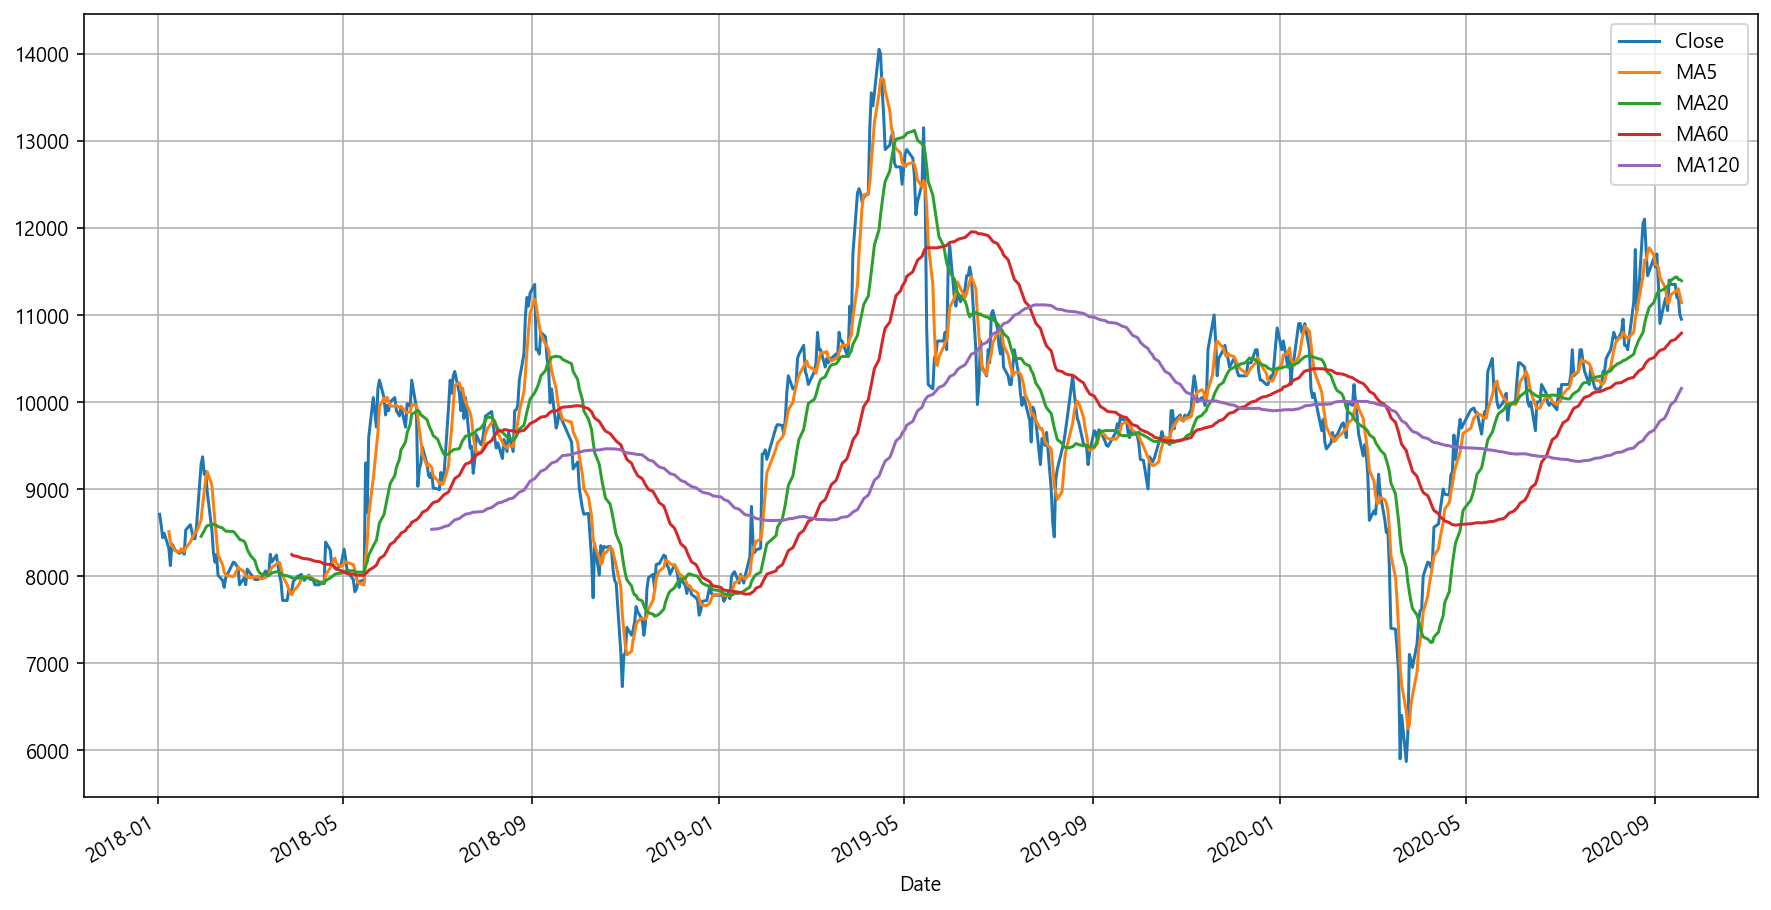

In [65]:
df_cost
ma5 = df_cost['Close'].rolling(window=5).mean()
df_cost['MA5'] = ma5
ma_ls = [20,60,120]
for i in range(len(ma_ls)):
    a = df_cost['Close'].rolling(window=ma_ls[i]).mean()
    df_cost['MA'+str(ma_ls[i])] = a
df_cost.loc[:,['Close','MA5','MA20','MA60','MA120']].plot(figsize = (15,8),grid=True)

In [63]:
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus = False)

# 그래프가 노트북 안에 보이게 하기 위해
%matplotlib inline
#폰트가 선명하게 보이기 위해
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [122]:
a = ('a c','b d')
# a[0]
b = a[0].split(' ')[0]
b

'a'